# 1. Setup

In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use('seaborn')
mpl.rc('font', size=13)
mpl.rc('axes', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

plt.rcParams['figure.figsize'] = [20, 10] # For larger plots

In [66]:
# Load data
df_IR = pd.read_stata("./Data/DHS/BJIR71DT/BJIR71FL.DTA", convert_categoricals=False)
# df_IR = pd.read_stata("./Data/DHS/CDIR61DT/CDIR61FL.DTA", convert_categoricals=False)
# smaller dataset


Then, let's define a subset of features to use

In [67]:
# Subset of features
# background

edu = 'v106'
violence_justified = 'v744' # a-e
age = 'v012'
age_group = 'v013'
litteracy = 'v155'
media_paper = 'v157'
media_radio = 'v158'
media_tv = 'v159'
sample_weight = 'v005' # must be divided by 1e6
ever_married = 'v020'
# residence = 'v025'
time2water = 'v115'

has_elec = 'v119'
has_radio = 'v120'
has_tv = 'v121'

has_fridge='v122'
has_bicycle = 'v123'
has_moto = 'v124'
has_car = 'v125'
religion = 'v130'
ethnicity = 'v131'
place_of_residence = 'v134'
edu_attainment = 'v149'
relation2household_head='v150'
sex_household_head = 'v151'
age_household_head = 'v152'

has_phone_landline='v153'
has_phone_mobile='v169a'
use_internet = 'v171a'
use_internet_last_month = 'v171b'
wealth_index = 'v191'

total_child_born = 'v201'
num_sons_died = 'v206'
num_daughters_died = 'v207'
num_dead_child = 'num_dead_child'
num_living_child = 'v218'


selected_for_dom_violence_interview = 'v044'

husband_edu_level = 'v701'# 's904'
husband_occupation = 's908a'
resp_occupation = 's913a'

# Domestic violence
is_currently_in_union= 'v502'
weight_dom_violence = 'd005'
control_issues = 'd101' #a-j
num_control_issues = 'd102'
emotional_violence = "d103" # a-f
emotional_violence_any = 'emotional_violence_any' #'d104'
physical_violence = 'd105' # a-n detailed acts of violence
physical_violence_less_severe = 'd106'
physical_violence_severe = 'd107'
sexual_violence = 'd108'

violence = 'violence'
# any_violence = 'd105' or 'd106' or 'd107'

violence_to_husband ='d112'
partner_drinks_alcohol='d113'
partner_drinks_alcohol_freq = 'd114'
sought_help = 'd119' # a to xk; y=no one
mother_beaten = 'd121'


edu_w = 'v106' # education level women, value =0-3
edu_m = 'mv106' # education level men, 
#Age (v012) is recorded in
#completed years, and is typically reported in 5-year groups (v013). 
# age_group_w = "v013"
# Info for men is in the Men's individual recode (MR) dataset



list_col0 = ['caseid', 'v000', sample_weight,
            edu, age, age_group, litteracy,
            media_paper, media_radio, media_tv,
            ever_married, 
            has_elec, has_radio, has_tv, has_fridge, has_bicycle, has_car, has_moto, 
            has_phone_landline, 
#             has_phone_mobile,
            religion, ethnicity,
            place_of_residence, age_household_head,
            relation2household_head,
            wealth_index,
            total_child_born, num_living_child, 
            
            husband_edu_level,
#             husband_occupation, resp_occupation,
            
            
            selected_for_dom_violence_interview, weight_dom_violence,
            is_currently_in_union, num_control_issues, #emotional_violence_any, 
            physical_violence_less_severe, physical_violence_severe, sexual_violence,
            partner_drinks_alcohol, partner_drinks_alcohol_freq, #sought_help,
            mother_beaten
           ]



# 2. Data cleaning

In [68]:
# Prepare clean format for multiple questions

# Violence_justified
# =======
'''
V744A                  Beating justified if wife goes out without tell 6103    1    N    I    1    0   No   No
                               0  No
                               1  Yes
                               8  Don't know
                           (m) 9  Missing
                          (na)    Not applicable
'''
# I assume 0 if v744 in [0, 8, 9, na]; 1 otherwise


# Control issues
# =======
'''
D101A                  Husband/partner jealous if respondent talks wit 8272    1    N    I    1    0   No   No
                               0  No
                               1  Yes
                               8  Don't know
                           (m) 9  Missing
                          (na)    Not applicable
'''
# For cleaning: same as previous

# Physical or sexual violence
# =======
'''
D105A                  Ever been pushed, shook or had something thrown 8291    1    N    I    1    0   No   No
                               0  Never
                               1  Often
                               2  Sometimes
                               3  Yes, but not in the last 12 months
                               4  Yes, but frequency in last 12 months missing
                           (m) 9  Missing
                          (na)    Not applicable
'''
# Let's consider true if hit during the past 12 months only
# So, we clean as 0 if d105a in [0, 2,3,4,9,na]


# Emotional violence
# =======
'''
D103A                  Ever been humiliated by husband/partner         8284    1    N    I    1    0   No   No
                               0  Never
                               1  Often
                               2  Sometimes
                               3  Yes, but not in the last 12 months
                               4  Yes, but frequency in last 12 months missing
                           (m) 9  Missing
                          (na)    Not applicable
'''
# Same as physicial violence for cleaning



cleaning_dict = {
     violence_justified: {'num_questions': 5, 'values_0': [8,9]},
     control_issues:     {'num_questions': 10, 'values_0': [8,9]},
     physical_violence:  {'num_questions': 14, 'values_0': [2,3,4,9]},
     emotional_violence: {'num_questions': 6, 'values_0': [2,3,4,9]},
     }
        

In [69]:
# Add multiple questions to list_col
list_col = list_col0.copy()
for key in cleaning_dict.keys():
    cleaning_dict[key]['list_col'] = [key + letter for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]]
    list_col += cleaning_dict[key]['list_col']

In [70]:
# Create a subset dataframe that contains only the chosen columns 
# and only for women who are married and took the domestic violence interview
df = df_IR[list_col].copy()
df = df[df[is_currently_in_union]==1]
df = df[df[selected_for_dom_violence_interview]==1]


In [71]:
for key in cleaning_dict.keys():
    df[key + '_sum'] = 0
    for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]:
        df[key + letter].fillna(0, inplace=True) # There shouldn't be missing na because of preselection of samples, but just in case
        for i in cleaning_dict[key]['values_0']:
            df.loc[df[key +  letter] == i,key + letter] = 0
        df[key + '_sum'] += df[key +  letter]
        
        # Check that assignment is correct
        assert df[key + letter].max() <= 1
#         print(key + letter + ":", df[key + letter].max())

In [72]:
# Feature engineering
df[num_dead_child] = df[total_child_born] - df[num_living_child]

In [73]:
# Weighting features
# df[violence_justified + '_weighted'] = df[violence_justified]*df[sample_weight]/1e6
# df[violence + '_weighted'] = df[violence]*df[sample_weight]/1e6



# 3. Exploratory data analysis

d105_sum,0.0,1.0
v744_sum,,
0,2762,100
1,1234,89


<AxesSubplot:title={'center':'Number of respondents for each class of score (only respondent experiencing domestic violence)'}, xlabel='v744_sum', ylabel='1.0'>

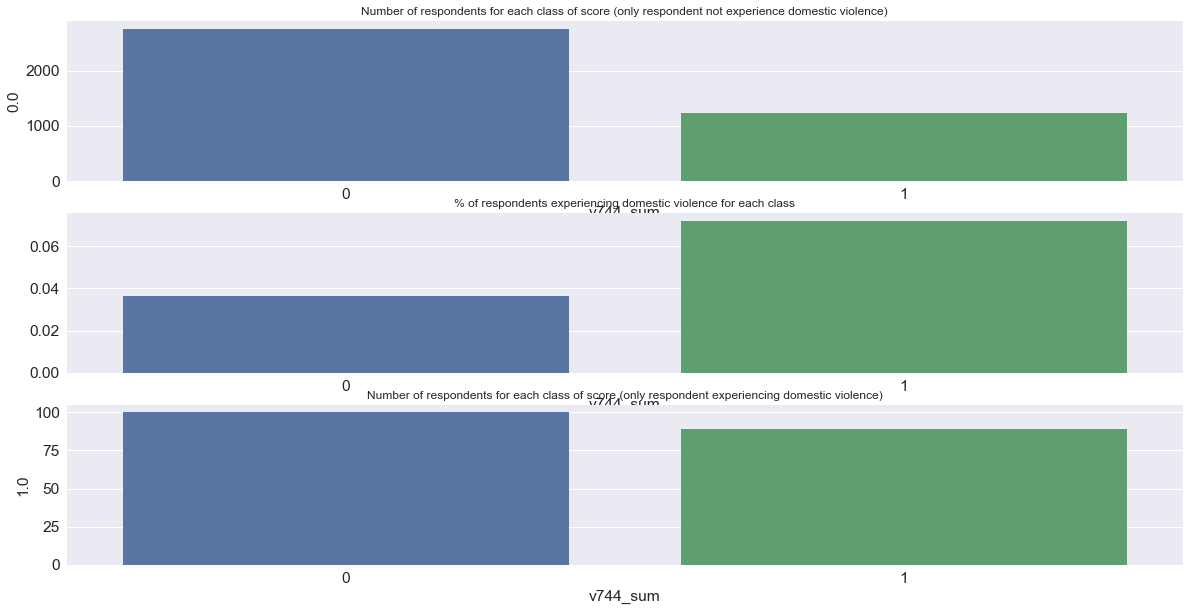

In [74]:
temp = df[[violence_justified + '_sum', physical_violence + '_sum']].copy()
temp['value'] = 1
temp.loc[temp[physical_violence + '_sum']>=1, physical_violence + '_sum']=1
temp.loc[temp[violence_justified + '_sum']>=1, violence_justified + '_sum']=1
temp_pivot = temp.pivot_table(columns=[physical_violence + '_sum'],
                              index=[violence_justified + '_sum'],
                              values='value',aggfunc='count')
display(temp_pivot)

plt.subplot(311)
plt.title('Number of respondents for each class of score (only respondent not experience domestic violence)')
sns.barplot(x=temp_pivot.index, y=temp_pivot.loc[:,0])
plt.subplot(312)
plt.title('% of respondents experiencing domestic violence for each class')
sns.barplot(x=temp_pivot.index, y=temp_pivot.loc[:,1]/temp_pivot.loc[:,0])
plt.subplot(313)
plt.title('Number of respondents for each class of score (only respondent experiencing domestic violence)')
sns.barplot(x=temp_pivot.index, y=temp_pivot.loc[:,1])


- subplot(1) most respondents answered no to every question (ie v744_sum == 0)
- subplot(2) Given the v744 score, the probability to experience violence is higher for higher scores (i.e., P(A|B), where A is score and B is violence)
- subplot(3) since there are many more people with a score of 0, most people experiencing violence scored 0 (i.e. P(B|A))

The results from subplot 2 and 3, are typical examples of bayesian probability.


<AxesSubplot:xlabel='d105_sum', ylabel='v744_sum'>

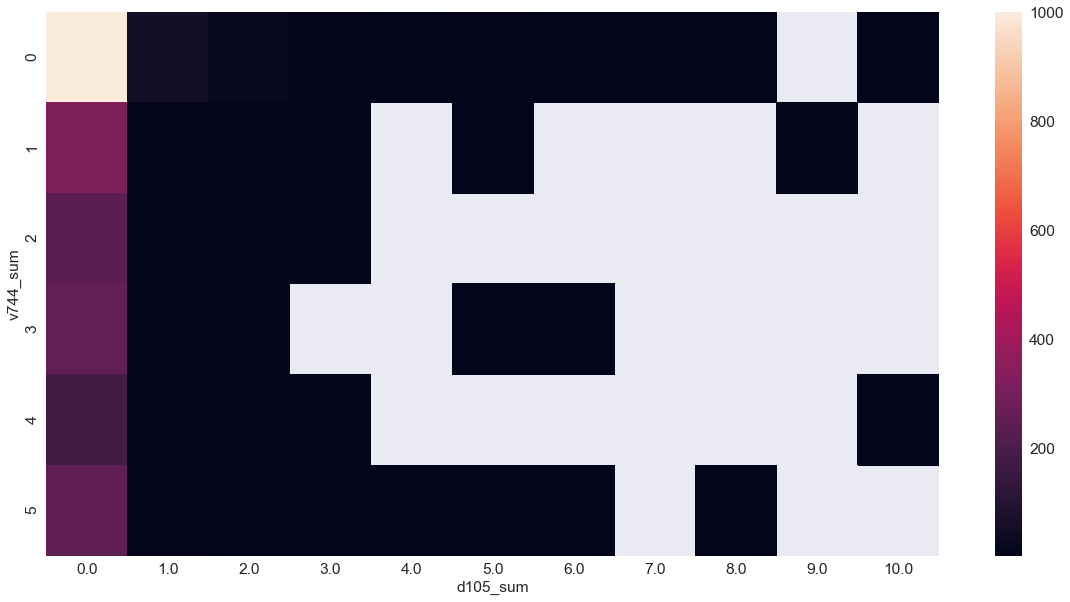

In [75]:
temp = df[[violence_justified + '_sum', physical_violence + '_sum']].copy()
temp['value'] = 1
# temp.loc[temp[physical_violence + '_sum']>=1, physical_violence + '_sum']=1
# temp.loc[temp[violence_justified + '_sum']>=1, violence_justified + '_sum']=1
temp_pivot = temp.pivot_table(columns=df[physical_violence + '_sum'],
                              index=[violence_justified + '_sum'],
                              values='value',aggfunc='count')

sns.heatmap(temp_pivot,vmax=1000)

### What is the most common form of physical+sexual domestic violence?

In [76]:
key = physical_violence
physical_violence_questions_sum = df[[key + letter for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]]].sum()
num_physical_violence_respondent = (df[physical_violence + '_sum']>0).sum()

<AxesSubplot:>

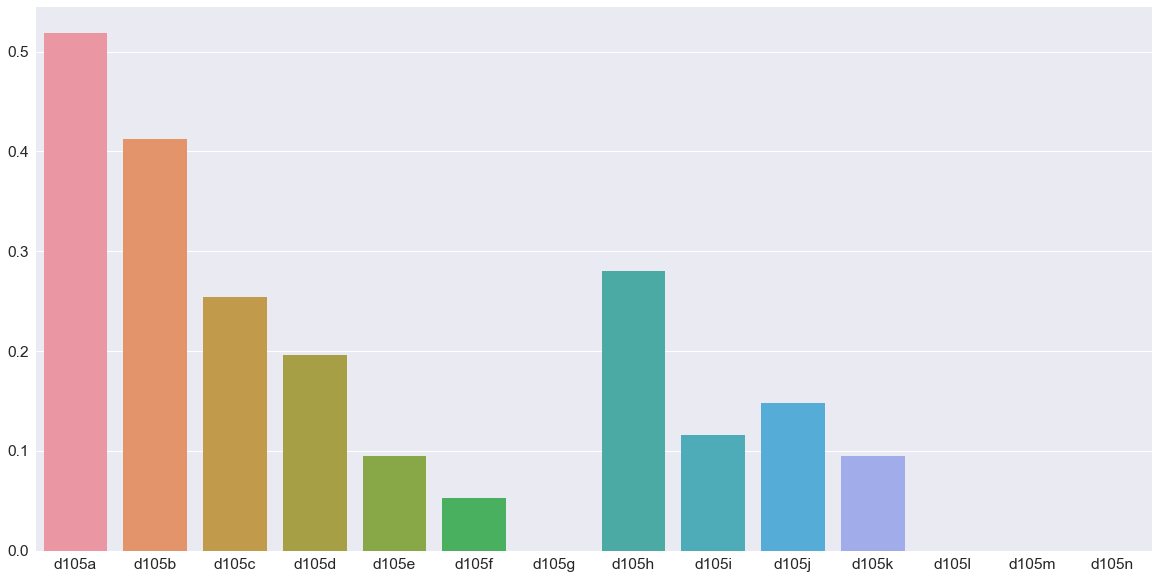

In [77]:
sns.barplot(y=physical_violence_questions_sum/num_physical_violence_respondent, x=physical_violence_questions_sum.index)

### What are forms of violence that occur together?
    
    

In [78]:
list_col_a = cleaning_dict[emotional_violence]['list_col']
list_col_b = cleaning_dict[physical_violence]['list_col']
list_col = list_col_a + list_col_b
temp = df[[emotional_violence + "_sum", physical_violence + "_sum"]].copy()
# temp_phy = df[physical_violence + "_sum"]

temp[emotional_violence + "_sum"] = temp[emotional_violence + "_sum"]>0
temp[physical_violence + "_sum"] = temp[physical_violence + "_sum"]>0

temp.loc[temp[emotional_violence + "_sum"]==1,physical_violence + "_sum"].sum()/temp.shape[0]
# temp.sum()/temp.shape[0]*100
(df[cleaning_dict[physical_violence]['list_col']].sum(axis=1)>0).sum()
# temp[emotional_violence + "_sum"].sum()
# # temp = df[list_col]
# co_occurence = (temp.T@temp)#.values
# for i in range(co_occurence.shape[0]):
#     co_occurence.iloc[i,:] /= co_occurence.iloc[i,i]
    
# sns.heatmap(co_occurence*100,annot=True)
# _ = plt.title("Co-occurence of positive physical or sexual violence acts in the last 12 months")

189

In [79]:
# Select some features for mutual information analysis
list_col_model = [edu, age, age_group, litteracy,
            media_paper, media_radio, media_tv,has_elec, has_radio, has_tv, has_fridge, has_bicycle, has_car, has_moto, 
            has_phone_landline, 
#             has_phone_mobile,
            religion, ethnicity,
#             place_of_residence, 
            age_household_head,
            relation2household_head,
            wealth_index,
            total_child_born, num_living_child, num_dead_child, 
            
            
            husband_edu_level, 
#             num_control_issues,
            partner_drinks_alcohol, partner_drinks_alcohol_freq,
            control_issues + '_sum',
            violence_justified + '_sum',
#             violence_justified,
            emotional_violence + '_sum',
#             emotional_violence_any,
            physical_violence + '_sum',
            
            mother_beaten,
#             husband_occupation, resp_occupation,
            ]
X = df[list_col_model].copy()


# for key in cleaning_dict.keys():
#     cleaning_dict[key]['list_col'] = [key + letter for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]]
#     list_col += cleaning_dict[key]['list_col']

# X.loc[:,husband_occupation] = X.loc[:,husband_occupation].astype('int8') # /!\ contains "8" as Nan
# X.loc[:,resp_occupation] = X.loc[:,resp_occupation].astype('int8') # /!\ contains "8" as Nan

# replace not applicable by "doesn't drink" for alcohol related question
for col in [partner_drinks_alcohol, partner_drinks_alcohol_freq, mother_beaten]:
    X[col].fillna(0, inplace=True)
    


# feature engineering
age_diff = 'age_diff'
age_ratio = 'age_ratio'
X[age_diff] = X[age] - X[age_household_head]

X.loc[:,'v701'].fillna(0,inplace=True) # only 2 missing values in Congo, 0 in Benin

# cast the following columns as int8 to treat them as discrete features
for col in [partner_drinks_alcohol, partner_drinks_alcohol_freq, mother_beaten, relation2household_head,
           husband_edu_level]:#, emotional_violence_any]:    
    X.loc[:,col] = X.loc[:,col].astype('int8') # /!\ contains "8" as Nan

    
# cast the following columns a floats continuous features
for col in [total_child_born, num_living_child, num_dead_child, age, age_household_head, age_diff,
           violence_justified + '_sum', 
            emotional_violence + '_sum',
            physical_violence + '_sum', 
            control_issues + '_sum',
            wealth_index]:
    X[col] = X[col].astype(float)


    
    
discrete_features = X.dtypes == 'int8'
X.dropna(inplace=True)
# X.dropna().info()

In [80]:
# Mutual information classification
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores



def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


In [81]:
# Let's try subsampling the majority class (no violence) to get better classification on the minority class (i.e. the class of interest)
from sklearn.model_selection import train_test_split

def subsample(X,y,imbalance_fac=1):
    y_select = df[physical_violence + "_sum"]>0
    y_negative = y[y_select==0].copy()
    y_positive = y[y_select==1].copy()
    
    X_negative = X.loc[y_select==0,:].copy()
    X_positive = X.loc[y_select==1,:].copy()
    
#     # duplicate positive cases
#     for i in range(4):
#         y_positive = np.concatenate([y_positive, y_positive])
#         X_positive = np.concatenate([X_positive, X_positive],axis=0)
    
    # subsample negative cases
    _, X_negative_sub, _, y_negative_sub = train_test_split(X_negative,y_negative, test_size=imbalance_fac*len(y_positive))#, stratify=True )
    return (pd.DataFrame(np.concatenate([X_negative_sub,X_positive]), columns=X.columns), 
            pd.Series(np.concatenate([y_negative_sub,y_positive]), ))


# y = df[violence_justified + '_sum']>0
# this_X = X.drop(columns=[violence_justified + "_sum"] )# +cleaning_dict[violence_justified]['list_col'])
# this_X, y = subsample(this_X,y)      
# y.shape

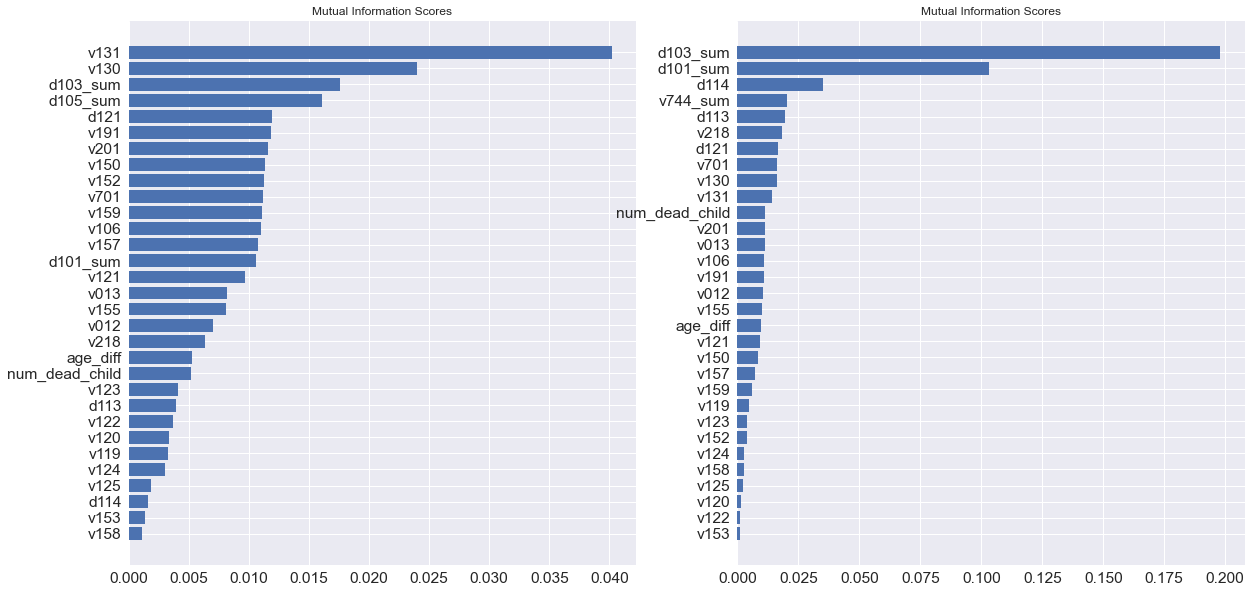

In [82]:
for itarget, target_feature in enumerate([violence_justified, physical_violence]):
    y = X[target_feature + '_sum']>0
    
    plt.subplot(1,2,itarget+1)
    this_X = X.drop(columns=[target_feature + "_sum"] )# +cleaning_dict[violence_justified]['list_col'])
#     display(this_X.isna().sum())
    discrete_features = this_X.dtypes == 'int8'

    mi_scores = pd.Series(np.zeros(this_X.columns.shape), index= this_X.columns)
    n = 20
    for i in range(n):
        X_sub, y_sub = subsample(this_X,y)       
        mi_scores += 1.0/n*make_mi_scores(X_sub, y_sub, discrete_features)
    plot_mi_scores(mi_scores)

In [83]:
# Clean up missing values
# X.info()
for col in X.columns:
    print(col + ": ", X[col].unique())

v106:  [0 2 1 3]
v012:  [28. 39. 43. 44. 36. 16. 48. 19. 25. 35. 30. 21. 17. 22. 46. 38. 18. 20.
 29. 23. 33. 24. 15. 42. 41. 32. 27. 40. 47. 37. 26. 49. 34. 45. 31.]
v013:  [3 5 6 1 7 4 2]
v155:  [0 2 1 3 4]
v157:  [0 2 1]
v158:  [1 0 2]
v159:  [0 1 2]
v119:  [0 1 7]
v120:  [1 0 7]
v121:  [0 1 7]
v122:  [0 7 1]
v123:  [1 0 7]
v125:  [0 7 1]
v124:  [1 0 7]
v153:  [0 7 1]
v130:  [ 3 10  4  1  6  2  5  8  7  9]
v131:  [ 2  7  3  6  4 96  8  5  1 97]
v152:  [45. 42. 65. 41. 57. 30. 35. 37. 73. 36. 74. 63. 40. 38. 55. 51. 86. 68.
 29. 46. 58. 32. 28. 23. 43. 53. 47. 59. 48. 33. 71. 22. 44. 49. 31. 25.
 27. 56. 64. 26. 54. 75. 52. 39. 34. 21. 77. 76. 60. 24. 70. 80. 50. 62.
 61. 20. 19. 67. 89. 66. 69. 95. 94. 18. 17. 92. 79. 81. 84. 85. 72. 87.
 78. 90. 91. 83. 82.]
v150:  [10  2  4  6  9  3 11  8  1 12  5  7]
v191:  [-51108. -78127. -59017. ...  40666.  99925. 291577.]
v201:  [ 4.  6.  3.  0.  7.  1.  5.  2.  9.  8. 10. 11. 13. 12. 16.]
v218:  [ 4.  3.  1.  0.  6.  2.  5.  7.  8.  9. 10. 

# Let's try prediction

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import GridSearchCV

y = X[physical_violence + "_sum"]>0
# y = y[df['v119']!=7]
this_X = X.drop(columns=[physical_violence + "_sum"])
discrete_features = this_X.dtypes == 'int8'
X_model = pd.get_dummies(this_X, columns=this_X.columns[discrete_features])
imbalance_fac = 2
X_model, y = subsample(X_model,y, imbalance_fac=imbalance_fac)      
X_train, X_test, y_train, y_test = train_test_split(X_model.values,y.values)

param_grid = dict(max_depth=[3,4,5,6,7], 
                 min_samples_leaf=[0.05, 0.1, 0.15, 0.2])

 
# clf = DecisionTreeClassifier(max_depth=5, 
#                              class_weight={0:1.0/(imbalance_fac+1), 1:1.0-(1.0/(imbalance_fac+1))}, 
#                              min_samples_leaf=0.1)
clf = DecisionTreeClassifier(
                             class_weight={0:1.0/(imbalance_fac+1), 1:1.0-(1.0/(imbalance_fac+1))}, 
                             )

clf_cv = GridSearchCV(clf, param_grid, cv=5)




clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(confusion_matrix(y_test, y_pred)/y_test.shape[0])
classif_dict = classification_report(y_test,y_pred, output_dict=True)
print("f1_score:", classif_dict['True']['f1-score'])
print(classification_report(y_test,y_pred))

[[0.51408451 0.17605634]
 [0.06338028 0.24647887]]
f1_score: 0.673076923076923
              precision    recall  f1-score   support

       False       0.89      0.74      0.81        98
        True       0.58      0.80      0.67        44

    accuracy                           0.76       142
   macro avg       0.74      0.77      0.74       142
weighted avg       0.80      0.76      0.77       142



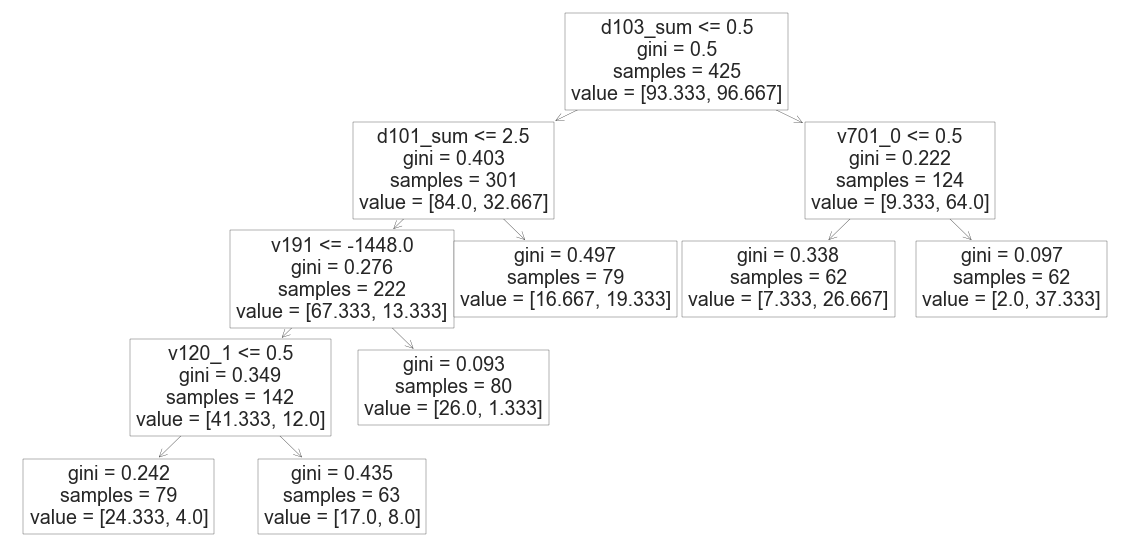

In [85]:
_ = tree.plot_tree(clf, feature_names=X_model.columns)

In [21]:
X_model.shape

(10964, 99)

In [22]:
X_model.iloc[:,9]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
15918    0.0
15921    0.0
15923    0.0
15924    0.0
15926    0.0
Name: emotional_violence_sum, Length: 10964, dtype: float64

In [23]:
np.sum(np.abs(y_test.values-y_pred))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
np.sum(y_test.values.astype(int) - y_pred.astype(int))

In [337]:
cleaning_dict

{'v744': {'num_questions': 5,
  'values_0': [8, 9],
  'list_col': ['v744a', 'v744b', 'v744c', 'v744d', 'v744e']},
 'd101': {'num_questions': 10,
  'values_0': [8, 9],
  'list_col': ['d101a',
   'd101b',
   'd101c',
   'd101d',
   'd101e',
   'd101f',
   'd101g',
   'd101h',
   'd101i',
   'd101j']},
 'd105': {'num_questions': 14,
  'values_0': [2, 3, 4, 9],
  'list_col': ['d105a',
   'd105b',
   'd105c',
   'd105d',
   'd105e',
   'd105f',
   'd105g',
   'd105h',
   'd105i',
   'd105j',
   'd105k',
   'd105l',
   'd105m',
   'd105n']},
 'd103': {'num_questions': 6,
  'values_0': [2, 3, 4, 9],
  'list_col': ['d103a', 'd103b', 'd103c', 'd103d', 'd103e', 'd103f']}}

In [35]:
# For Ettore
df[cleaning_dict['v744']['list_col'] + cleaning_dict['d105']['list_col'] + cleaning_dict['d103']['list_col']].astype(int).to_csv('data_Ettore.csv')

'd105'